<a href="https://www.kaggle.com/code/akshatpathak/us-patents?scriptVersionId=95815548" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import regex as re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model,Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

/kaggle/input/glove-embeddings/glove.6B.200d.txt
/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt
/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv')
test = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv')
sub = pd.read_csv('/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv')
embedding  = '/kaggle/input/glove-embeddings/glove.6B.50d.txt'

In [3]:
def basic_exploration(df):
    print(f"-----STARTED--EXPLORING----\n")
    print(f"\n {df.head(5)}\n")
    print(f"\n the size of dataframe is {df.shape}\n")
    print(f"\n {df.info()}\n")
    print(f"\n{df.isnull().any()}\n")
    print(f"-----ENDED EXPLORING-------\n")

basic_exploration(train)
basic_exploration(test)    

-----STARTED--EXPLORING----


                  id     anchor                  target context  score
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75
2  36d72442aefd8232  abatement         active catalyst     A47   0.25
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00


 the size of dataframe is (36473, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB

 None


id         False
anchor     False
target     False
context    False
score 

Total no. of unique anchors 733

Min value of score : 0.0 and Max value of score : 1.0

Top 20 anchor categories are anchor
component composite coating         152
sheet supply roller                 150
source voltage                      140
perfluoroalkyl group                136
el display                          135
average pore size                   133
speed control means                 130
parallel orientation                127
displacement mechanism              124
cathode layer                       118
flow openings                       117
electromagnetic radiation source    115
overall weight                      114
central flow path                   111
elastic assembly                    109
dimensional location                109
hydrocarbyl substituted succinic    108
conductor particles                 108
oxidizing enzyme                    107
stabilizer members                  107
Name: id, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


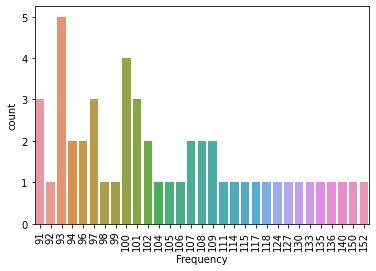

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


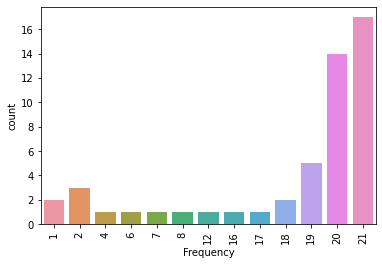

In [4]:
def hist(df):
    sns.countplot(df.id)
    plt.xlabel("Frequency")
    plt.xticks(rotation = 90)
    plt.show()
    
def eda(df):
    print(f"Total no. of unique anchors {len(np.unique(df.anchor).tolist())}\n")
    print(f"Min value of score : {np.min(df.score)} and Max value of score : {np.max(df.score)}\n")
    print(f"Top 20 anchor categories are {df.groupby('anchor').count().sort_values('score', axis = 0, ascending = False)['id'][:20]}")
    top = df.groupby('anchor').count().sort_values('score', axis = 0, ascending = False)[:50]
    bottom = df.groupby('anchor').count().sort_values('score', axis = 0, ascending = True)[:50]
    hist(top)
    hist(bottom)
eda(train)    
    
    

In [5]:
stops = set(stopwords.words("english"))
def clean_content(table):
    content = table.target
    content = content.apply(lambda x: x.lower())
    #Removing any character which does not match to letter,digit or underscore
    content = content.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    #Removing space,newline,tab
    content = content.apply(lambda x: re.sub(r'\s',' ',x))
    #Removing punctuation
    content = content.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    #Tokenizing data
    content = content.apply(lambda x: word_tokenize(x))
    #Removing stopwords
    content = content.apply(lambda x: [i for i in x if i not in stops])
    return(content)
train['words'] = clean_content(train)
test['words'] = clean_content(test)

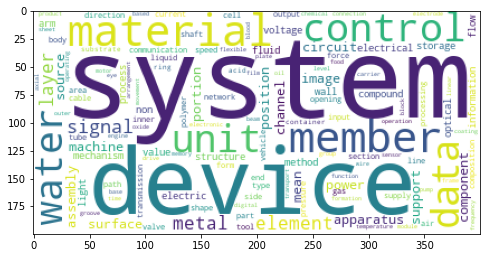

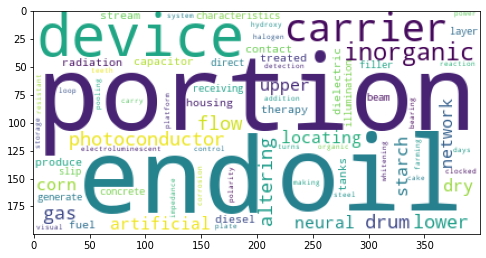

In [6]:
def wordcloud(df):
    buffer = " " 
    for x in df.words:
        for y in x:
            buffer += " " + y
    plt.figure(figsize=(8,10))
    wc = WordCloud(background_color= 'white', max_words=1000,random_state=1).generate(buffer)
    plt.imshow(wc)
    plt.show() 
wordcloud(train)
wordcloud(test)

In [7]:
def Stemming(df):
    wordnet = WordNetLemmatizer()
    df['words']= df['words'].apply(lambda x:[wordnet.lemmatize(i,pos='v') for i in x])
Stemming(train)
Stemming(test)

In [8]:
list_of_words_train = train['words'].values

In [9]:
list_of_words_train

array([list(['abatement', 'pollution']), list(['act', 'abate']),
       list(['active', 'catalyst']), ..., list(['wooden', 'handle']),
       list(['wooden', 'material']), list(['wooden', 'substrate'])],
      dtype=object)

In [10]:
test.head(5)

,id,anchor,target,context,words
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,"[inorganic, photoconductor, drum]"
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,"[alter, gas, flow]"
2,36baf228038e314b,lower trunnion,lower locating,B60,"[lower, locate]"
3,1f37ead645e7f0c8,cap component,upper portion,D06,"[upper, portion]"
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,"[artificial, neural, network]"


In [11]:
maxlen = 100
max_features = 10000 
embed_size = 50

In [12]:
x_train = train['words']
y_train = train['score']
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
seq_train = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(seq_train, maxlen=maxlen)

In [13]:
def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding))
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.020940498, 0.6441043)

In [14]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= nb_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [15]:
model = Sequential()
model.add(Embedding(nb_words, embed_size, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
model.add(GlobalMaxPool1D())
model.add(Dense(50,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

2022-05-17 04:50:50.959291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 04:50:51.062310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 04:50:51.063113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 04:50:51.064279: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.1);

2022-05-17 04:50:53.932593: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
1026/1026 [==============================] - 957s 927ms/step - loss: 0.0666 - val_loss: 0.0747
Epoch 2/2
1026/1026 [==============================] - 962s 938ms/step - loss: 0.0590 - val_loss: 0.0690


In [17]:
test.head(5)

,id,anchor,target,context,words
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,"[inorganic, photoconductor, drum]"
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,"[alter, gas, flow]"
2,36baf228038e314b,lower trunnion,lower locating,B60,"[lower, locate]"
3,1f37ead645e7f0c8,cap component,upper portion,D06,"[upper, portion]"
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,"[artificial, neural, network]"


In [18]:
x_test = test['words']
x_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(x_test, maxlen=maxlen)

In [19]:
predict = model.predict(X_test)
test['label'] = predict
test.head()

,id,anchor,target,context,words,label
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,"[inorganic, photoconductor, drum]",0.271074
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,"[alter, gas, flow]",0.487362
2,36baf228038e314b,lower trunnion,lower locating,B60,"[lower, locate]",0.365083
3,1f37ead645e7f0c8,cap component,upper portion,D06,"[upper, portion]",0.326573
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,"[artificial, neural, network]",0.247402


In [20]:
ans = test.label
sub['score'] = ans
sub.to_csv("submission.csv",index=False)

In [21]:
sub.head(5)

,id,score
0,4112d61851461f60,0.271074
1,09e418c93a776564,0.487362
2,36baf228038e314b,0.365083
3,1f37ead645e7f0c8,0.326573
4,71a5b6ad068d531f,0.247402
